In [8]:
# --- ライブラリのインポート ---
# データ操作
import pandas as pd
import numpy as np

# 可視化
import matplotlib.pyplot as plt
import seaborn as sns

# ファイル操作
import glob
import os

# Jupyter Notebookの表示設定など
from IPython.display import display, clear_output

# スタイル設定
sns.set_theme(style="whitegrid")
print("Libraries imported successfully.")

Libraries imported successfully.


In [9]:
# --- 分析対象の実験パラメータを設定 ---
# ここで指定した値に基づいて、参照するファイルパスが自動的に決まります。

ALGORITHM = 'efwa'
PROBLEM_NAME = 'SphereFunction'   # ★★★ ここを変更 ★★★
DIMENSION = 20                    # ★★★ ここを変更 ★★★

# --- パスを動的に生成 ---
# 最終結果サマリーCSVのパス
results_csv_path = f"results/{ALGORITHM}_{PROBLEM_NAME}_d{DIMENSION}.csv"

# 収束履歴フォルダのパス
history_folder_path = f"results/histories/{ALGORITHM}_{PROBLEM_NAME}_d{DIMENSION}"

print(f"分析対象のサマリーファイル: {results_csv_path}")
print(f"分析対象の履歴フォルダ: {history_folder_path}")

分析対象のサマリーファイル: results/efwa_SphereFunction_d20.csv
分析対象の履歴フォルダ: results/histories/efwa_SphereFunction_d20


  algorithm  run  dimension  final_fitness   runtime_ms
0       pso    1         30   1.657808e+02  5552.283525
1       pso    2         30   5.021423e+00  5405.359268
2       pso    3         30   1.000006e+06  5559.098721
3       pso    4         30   1.000002e+06  5542.159796
4       pso    5         30   1.000006e+06  5988.640308


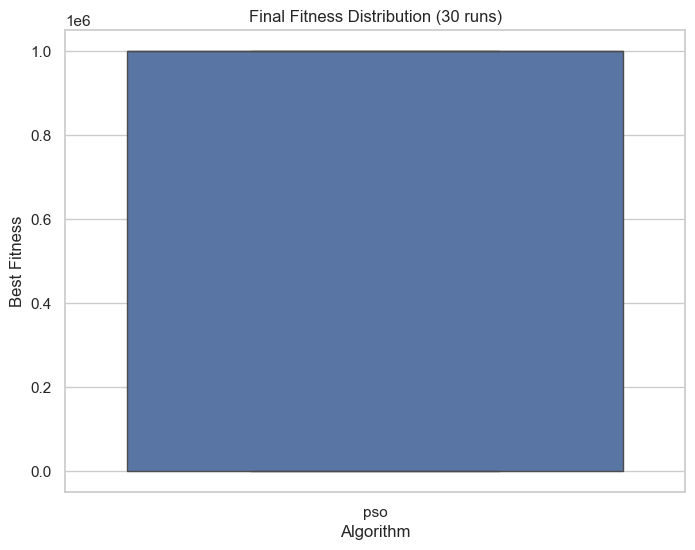

In [10]:
# run_experiment.pyで保存したCSVファイルのパス
csv_path = 'results/pso_RosenbrockFunction_d30.csv'

# CSVファイルを読み込む
try:
    df = pd.read_csv(csv_path)
    
    # 読み込んだデータの確認
    print(df.head())
    
    # 箱ひげ図で可視化
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df, x='algorithm', y='final_fitness')
    
    plt.title('Final Fitness Distribution (30 runs)')
    plt.ylabel('Best Fitness')
    plt.xlabel('Algorithm')
    plt.show()
    
except FileNotFoundError:
    print(f"Error: {csv_path} not found.")
    print("Please run 'python run_experiment.py --algorithm pso' first.")

In [11]:
# # 必要なクラスをインポート
# from algorithms import PSO
# from problems import SphereFunction

# # パラメータ設定
# DIMENSION = 20
# MAX_ITERATIONS = 10000

# # 1回だけ実行するためのインスタンスを作成
# problem_instance = SphereFunction(dimension=DIMENSION)
# pso_instance = PSO(problem=problem_instance, max_iterations=MAX_ITERATIONS)

# print("Running a single optimization in the notebook...")

# # 変更したoptimizeメソッドを実行して、履歴を受け取る
# best_pos, final_fit, history = pso_instance.optimize()

# print(f"Optimization finished. Final fitness: {final_fit}")

# # 収束曲線（折れ線グラフ）をプロット
# plt.figure(figsize=(10, 6))
# plt.plot(history)
# plt.title('Convergence Curve for a Single Run')
# plt.xlabel('Iteration')
# plt.ylabel('Best Fitness Value')
# plt.yscale('log') # y軸を対数スケールにすると、初期の急激な変化が見やすい
# plt.grid(True, which="both", ls="--")
# plt.show()

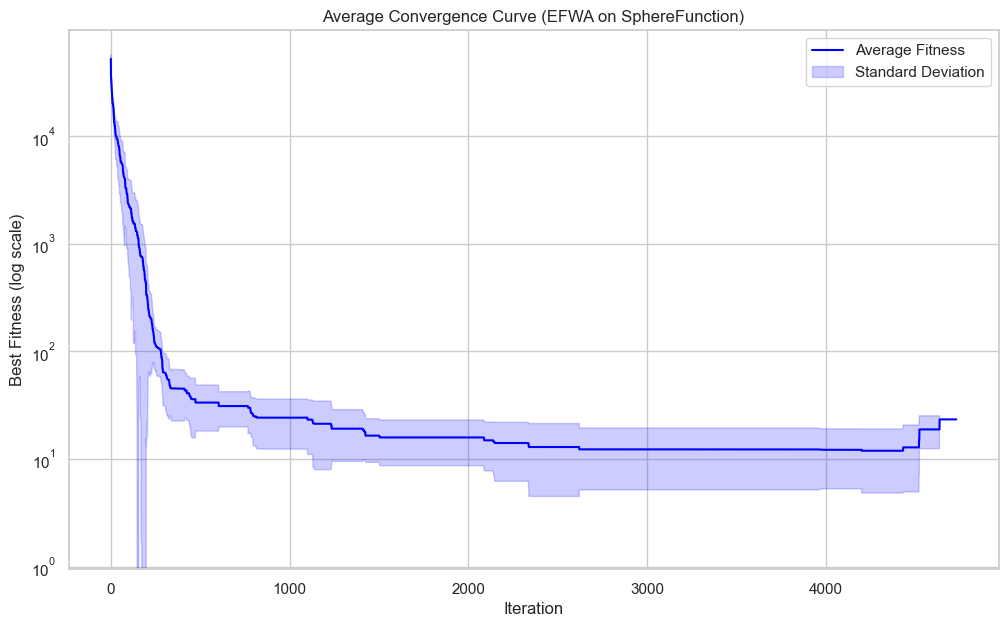

In [12]:
# --- 平均収束曲線の描画 ---
# セル2で設定したパスを使って、該当する履歴データを読み込みます。

try:
    all_histories = []
    # history_folder_path を使ってファイル検索
    csv_files = glob.glob(f'{history_folder_path}/run_*.csv')

    if not csv_files:
        raise FileNotFoundError # ファイルが見つからなければエラーを発生させる

    for file_path in csv_files:
        df_history = pd.read_csv(file_path)
        all_histories.append(df_history['fitness'])

    # ...以降のグラフ描画コードは変更なし...
    df_all_histories = pd.concat(all_histories, axis=1)
    mean_fitness = df_all_histories.mean(axis=1)
    std_fitness = df_all_histories.std(axis=1)

    plt.figure(figsize=(12, 7))
    plt.plot(mean_fitness.index, mean_fitness, label='Average Fitness', color='blue')
    plt.fill_between(mean_fitness.index, 
                     mean_fitness - std_fitness, 
                     mean_fitness + std_fitness, 
                     color='blue', alpha=0.2, label='Standard Deviation')

    plt.title(f'Average Convergence Curve ({ALGORITHM.upper()} on {PROBLEM_NAME})')
    plt.xlabel('Iteration')
    plt.ylabel('Best Fitness (log scale)')
    plt.yscale('log')
    plt.legend()
    plt.show()

except FileNotFoundError:
    print(f"Error: History files not found in '{history_folder_path}'")
    print("Please check the settings in Cell 2 or ensure run_experiment.py has completed.")

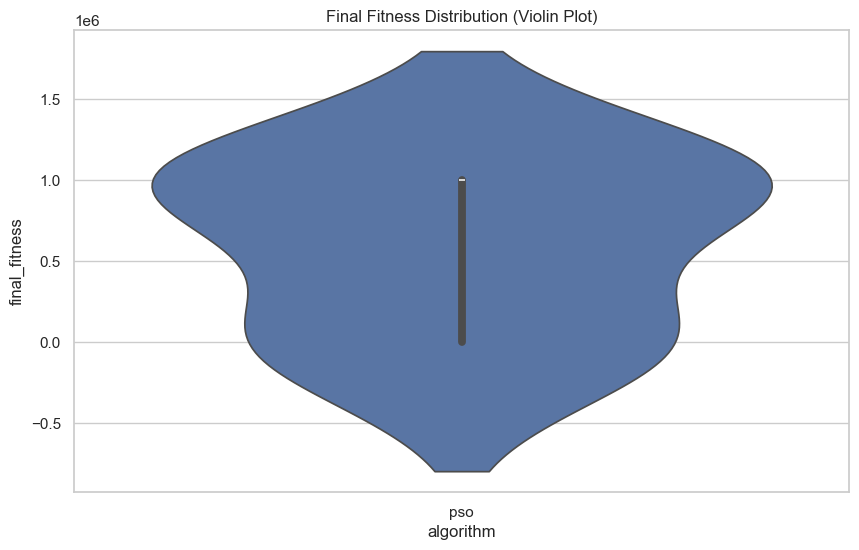

In [13]:
# run_experiment.pyで保存した最終結果のCSVを使用
df_results = pd.read_csv('results/pso_RosenbrockFunction_d30.csv')

plt.figure(figsize=(10, 6))
# バイオリンプロット
sns.violinplot(data=df_results, x='algorithm', y='final_fitness')
plt.title('Final Fitness Distribution (Violin Plot)')
plt.show()

In [14]:
# analysis.ipynb に追加するコードの例

import pandas as pd
from scipy.stats import mannwhitneyu # Scipyライブラリからマン・ホイットニーのU検定をインポート

# --- 比較したい2つの実験結果をロード ---
# analysis.ipynbのセル2で設定したパラメータが使えます
ALGORITHM_1 = 'pso'
ALGORITHM_2 = 'efwa'
PROBLEM_NAME = 'SphereFunction'
DIMENSION = 20

try:
    # 各アルゴリズムの結果CSVを読み込む
    df1 = pd.read_csv(f"results/{ALGORITHM_1}_{PROBLEM_NAME}_d{DIMENSION}.csv")
    df2 = pd.read_csv(f"results/{ALGORITHM_2}_{PROBLEM_NAME}_d{DIMENSION}.csv")

    # 最終評価値の列を取得
    fitness_1 = df1['final_fitness']
    fitness_2 = df2['final_fitness']

    # --- マン・ホイットニーのU検定を実行 ---
    stat, p_value = mannwhitneyu(fitness_1, fitness_2, alternative='two-sided')

    print(f"--- Statistical Test: {ALGORITHM_1.upper()} vs {ALGORITHM_2.upper()} on {PROBLEM_NAME} ---")
    print(f"P-value: {p_value:.4f}")

    # --- 結果の解釈 ---
    alpha = 0.05 # 有意水準
    if p_value < alpha:
        print(f"p < {alpha} なので、2つのアルゴリズムの性能には統計的に有意な差があると言えます。")
        # どちらの性能が良いかを示すために中央値を比較
        median_1 = fitness_1.median()
        median_2 = fitness_2.median()
        print(f"Median Fitness ({ALGORITHM_1.upper()}): {median_1:.4e}")
        print(f"Median Fitness ({ALGORITHM_2.upper()}): {median_2:.4e}")
        if median_1 < median_2:
            print(f"中央値の比較から、{ALGORITHM_1.upper()} の方が性能が良い可能性が高いです。")
        else:
            print(f"中央値の比較から、{ALGORITHM_2.upper()} の方が性能が良い可能性が高いです。")
    else:
        print(f"p >= {alpha} なので、2つのアルゴリズムの性能に統計的に有意な差があるとは言えません。")

except FileNotFoundError as e:
    print(f"エラー: 結果ファイルが見つかりません。 {e}")
    print("先に run_experiment.py または run_all_experiments.py を実行して結果を生成してください。")

--- Statistical Test: PSO vs EFWA on SphereFunction ---
P-value: 0.0000
p < 0.05 なので、2つのアルゴリズムの性能には統計的に有意な差があると言えます。
Median Fitness (PSO): 4.1991e-292
Median Fitness (EFWA): 8.3756e+00
中央値の比較から、PSO の方が性能が良い可能性が高いです。
